# Loss Graph & Hyperparameter Tune & Validation & Train
# Make sure forward pass works (for hard negative data)

## Setup & Dataset Import

### Setup

In [16]:
!pip install -U "ray[air]"

In [36]:
from functools import partial
import os
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split
# from ray import tune
# from ray.air import Checkpoint, session
# from ray.tune.schedulers import ASHAScheduler

### Hyperparameters

In [37]:
batch_size = 64
supervised = True
lrs = [1e-2,5e-3,1e-3,1e-4,1e-3]
momentums = [0.9,0.9,0.9,0.9,0.9]
weight_decays = [1e-5,5e-5,1e-3,1e-3,1e-5]
thresholds = [50,1000,1000,1000]
num_epochs = 15
records_per_epoch = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [38]:
# import MNIST
def load_mnist(data_dir="./data"):
  train_data = datasets.MNIST(
      root = data_dir,
      train = True,
      transform = ToTensor(),
      download = True,
  )
  test_data = datasets.MNIST(
      root = data_dir,
      train = False,
      transform = ToTensor(),
      download = True
  )
  return train_data,test_data

In [39]:
train_data, test_data = load_mnist()

In [40]:
# Dataloader
train_loader = DataLoader(train_data,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=1)

test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=1)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7e30800dd450>,
 <torch.utils.data.dataloader.DataLoader at 0x7e30800dea10>)

## Construct Negative Examples for Unsupervised Training



In [ ]:
filter = torch.tensor([[0.0625,0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]])

def blur(img,filter):
  # blur img using filter
  # params: filter --> torch.tensor(2*radius+1,2*radius+1)
  m,n = img.shape
  radius = (filter.shape[0]-1)//2
  new_img = torch.zeros(m,n)
  for i in range(m):
    for j in range(n):
      top,left,bottom,right = max(0,i-radius),max(0,j-radius),min(m-1,i+radius),min(m-1,j+radius)
      new_img[i][j] = sum([img[x][y]*filter[x-i+radius][y-j+radius]
                           for y in range(left,right+1) for x in range(top,bottom+1)])
  return new_img

def generate_negative_example():
  # construct a negative example for unsupervised case (3.2 in paper)
  mask = (torch.rand(28,28) > 0.5).long() # initiate as random bit image

  for i in range(6): # repeat blurring 6 times
    mask = blur(mask,filter)

  mask = (mask > 0.5).long() # mask

  index1,index2 = torch.randint(len(train_data),(2,))
  return (mask * train_data[index1][0] + (1-mask) * train_data[index2][0])

## Model Definition



In [41]:
# single-layer NN
class one_layer_net(torch.nn.Module):

    def __init__(self, in_size, out_size):
        super(one_layer_net, self).__init__()

        # hidden layer
        # self.layer = torch.nn.Sequential(
            # torch.nn.Flatten(), # nn.Flatten to standardize input shape
            # torch.nn.Linear(in_size, out_size),
            # torch.nn.ReLU() # activation function
        # )
        self.flatten = nn.Flatten()
        self.layer = nn.Linear(in_size, out_size)
        self.relu = nn.ReLU()

    def forward(self, x):
      f = self.flatten(x)
      l = self.layer(f)
      r = self.relu(l)
      return r

In [42]:
# full network
class net(nn.Module):
    # Constructor
    def __init__(self,in_size):
        super(net, self).__init__()
        self.layer1 = one_layer_net(in_size,2000)
        self.layer2 = one_layer_net(2000,2000)
        self.layer3 = one_layer_net(2000,2000)
        self.layer4 = one_layer_net(2000,2000)
        self.ln = nn.LayerNorm(2000) # layernorm

        # softmax layer for hard negative label generation
        self.out_layer = nn.Linear(6000, 10)

        self.layers = [self.layer1,self.layer2,self.layer3,self.layer4,self.out_layer]

    def forward(self,x):
        # x-->tensor (batch_size,channel,height,width)
        # return res --> tensor (batch_size,10)
        interms = []
        interm = x.detach().clone()

        for index in range(len(self.layers)-1):
          layer = self.layers[index] # linear layer
          output = layer(interm) # run the layer
          interm = self.ln(output) # layer-norm
          interms.append(interm.detach().clone()) # store normalized activity

        final_input = torch.cat(interms[1:],dim=1)
        res = self.out_layer(final_input) # final output layer
        return res

    def predict(self,x,device):
        # x-->tensor (batch_size,channel,height,width)
        # return labels --> tensor (batch_size,1)
        accumulate_goodness = torch.zeros(x.shape[0],10).to(device) # accumulate goodness for each label
        for i in range(10): # iterate through all labels
          interm = x.detach().clone()

          # update one-hot label encoding
          interm[:,:,0,:10] = 0
          interm[:,:,0,i] = 1

          for index in range(len(self.layers)-1):
            layer = self.layers[index]
            interm = layer(interm)

            if index > 0: # accumulate goodness for all activities but first hidden layer
              accumulate_goodness[:,i] = accumulate_goodness[:,i] + self.goodness(interm)

            if index + 1 < len(self.layers): # layernorm
              interm = self.ln(interm)
        return torch.argmax(accumulate_goodness,dim=1)

    def goodness(self,x):
        # goodness functions--sum of squares
        # input: x-->tensor (batch_size, ...) (arbitrary shape that starts with batch_size)
        # return goodness-->tensor (batch_size,1)
        x = x.reshape(x.shape[0],-1)
        return torch.sum(torch.square(x),dim=1)

    def criterion(self,x, threshold):
        # criterion function--mean(sigmoid(goodness - threshold))
        # input: x-->tensor (batch_size, ...) (arbitrary shape that starts with batch_size)
        # return loss-->float
        goodness = self.goodness(x)
        res = torch.mean(torch.sigmoid(goodness - threshold))
        # print(goodness,res)
        return res

    def construct_supervised_example(self,x,y,positive=True):
        # construct positive or negative examples for supervised training
        # x-->tensor (batch_size,channel,height,width)
        # y-->tensor (batch_size,)
        # return ans-->tensor (batch_size,channel,height,width)

        ans = x.detach().clone()

        if positive:
          # one-hot encoding
          ans[:,:,0,:10] = 0
          for i in range(x.shape[0]):
             ans[i,:,0,y[i]] = 1

        else:
          ans[:,:,0,:10] = 0.1 # initialize neutral label

          # run forward pass
          labels = self.forward(ans)

          for i in range(x.shape[0]):
             labels[i][y[i]] = -float('inf') # omit positive label
          prob = torch.softmax(labels,dim=1) # probability distribution to choose label
          negative_label = torch.multinomial(prob,1).squeeze() # choose from distribution

          # generate negative example from forward pass
          ans[:,:,0,:10] = 0
          for i in range(x.shape[0]):
              ans[i,:,0,negative_label[i]] = 1

        return ans

In [43]:
# create model
model = net(784)
model.to(device)

net(
  (layer1): one_layer_net(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): Linear(in_features=784, out_features=2000, bias=True)
    (relu): ReLU()
  )
  (layer2): one_layer_net(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): Linear(in_features=2000, out_features=2000, bias=True)
    (relu): ReLU()
  )
  (layer3): one_layer_net(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): Linear(in_features=2000, out_features=2000, bias=True)
    (relu): ReLU()
  )
  (layer4): one_layer_net(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): Linear(in_features=2000, out_features=2000, bias=True)
    (relu): ReLU()
  )
  (ln): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=6000, out_features=10, bias=True)
)

In [44]:
# apply xavier initialization on weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [45]:
pos_optimizers, neg_optimizers = [],[]
final_optimizer = torch.optim.SGD(model.layers[-1].parameters(), lr=lrs[-1], momentum = momentums[-1], weight_decay=weight_decays[-1], maximize=False)
# initialize each layer
for index in range(len(model.layers)):
    # layer & training initialization
    layer = model.layers[index]
    layer.apply(init_weights)
    # clip gradients to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_(parameters=layer.parameters(), max_norm=1,norm_type=2.0)
    # define optimizers
    if index < len(model.layers)-1:
      pos_optimizers.append(torch.optim.SGD(layer.parameters(), lr=lrs[index], momentum = momentums[index], weight_decay=weight_decays[index], maximize=True))
      neg_optimizers.append(torch.optim.SGD(layer.parameters(), lr=lrs[index], momentum = momentums[index], weight_decay=weight_decays[index], maximize=False))

In [46]:
# design loss function
def goodness_loss(pos_goodness,neg_goodness):
  # loss function intended for maximizing goodness in positive examples
  # and minimizing goodness in negative examples
  return torch.log(1+torch.exp(neg_goodness-pos_goodness))


# CrossEntropyLoss for final softmax layer optimization
ceLoss = nn.CrossEntropyLoss()

In [47]:
# model evaluation using test set
def test(model,test_loader,loss_func):
    # return loss-->float, accuracy-->float
    model.eval() # switch to eval mode
    with torch.no_grad(): # disable gradient calculation
        correct = 0
        total_loss = 0
        total_steps = 0
        total = 0
        for x, y in test_loader:
            x,y = x.to(device),y.to(device)
            # use forward to calculate loss
            labels = model.forward(x)
            loss = loss_func(labels,y)
            total_loss += loss
            total_steps += 1
            # use predict to predict accuracies
            predictions = model.predict(x,device)
            acc = torch.sum(predictions == y)
            correct += acc
            total += x.shape[0]
    model.train() # switch back to train mode
    return total_loss/total_steps, correct/total

## Hyperparemeter Tuning

In [31]:
# train function implementing Ray Tune for hyperparameter tuning
# train model
def train_tune(config, data_dir='./data'):

    # initialize model
    model = net(784)

    # configure device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # configure loss function and optimizers
    final_loss = config["final_loss"]
    pos_optimizers, neg_optimizers = [],[]
    final_optimizer = torch.optim.SGD(model.layers[-1].parameters(), lr=config['lrs'][-1], momentum = config['momentums'][-1], weight_decay=config['weight_decays'][-1], maximize=False)
    # iterate each layer
    for index in range(len(model.layers)):
        # layer & training initialization
        layer = model.layers[index]
        layer.apply(init_weights)
        # clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(parameters=layer.parameters(), max_norm=1,norm_type=2.0)
        # define optimizers
        if index < len(model.layers)-1:
          pos_optimizers.append(torch.optim.SGD(layer.parameters(), lr=config['lrs'][index], momentum = config['momentums'][index], weight_decay=config['weight_decays'][index], maximize=True))
          neg_optimizers.append(torch.optim.SGD(layer.parameters(), lr=config['lrs'][index], momentum = config['momentums'][index], weight_decay=config['weight_decays'][index], maximize=False))

    # configure state of model if checkpoint exists
    checkpoint = session.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        net.load_state_dict(checkpoint_state["net_state_dict"])
        for index in range(len(model.layers)-1):
          pos_optimizers[index].load_state_dict(checkpoint_state["optimizer_state_dict"]["pos"][index])
          neg_optimizers[index].load_state_dict(checkpoint_state["optimizer_state_dict"]["neg"][index])
        final_optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"]["final"])
    else:
        start_epoch = 0

    # load data
    train_data, test_data = load_mnist(data_dir)

    test_abs = int(len(train_data) * 0.9)
    train_subset, val_subset = random_split(
        train_data, [test_abs, len(train_data) - test_abs]
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=8
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=8
    )


    model.train()

    # variables for training output
    # total_pos_goodnesses,total_neg_goodnesses = [],[]
    # total_losses = []
    # test_accuracies = []
    total_step = len(train_loader)
    record_period = total_step//records_per_epoch

    for epoch in range(config["num_epochs"]):
        total_pos_goodness,total_neg_goodness = [0]*(len(model.layers)-1),[0]*(len(model.layers)-1)
        total_loss = 0
        # total_loss = [0]*len(model.layers)
        for i,(x,y) in enumerate(train_loader): # iterate through dataset
            x,y = x.to(device),y.to(device)
            if not config["supervised"]: # unsupervised training input
              pos_imgs = x.squeeze()
              neg_imgs = generate_negative_example().squeeze().to(device)
            else: # supervised learning input
              pos_imgs = model.construct_supervised_example(x,y,True)
              neg_imgs = model.construct_supervised_example(x,y,False)

            # intermediate variables
            pos_interms = []
            pos_interm = pos_imgs.clone()
            neg_interm = neg_imgs.clone()

            # iterate over intermediate layers
            for index in range(len(model.layers)-1):
              layer = model.layers[index]

              # positive pass
              pos_output = layer(pos_interm)
              pos_goodness = model.criterion(pos_output, threshold=config["thresholds"][index])
              pos_interm = model.ln(pos_output).detach()
              pos_interms.append(pos_interm.clone())

              # update variables
              total_pos_goodness[index] += pos_goodness

              # clear gradients for this training step
              pos_optimizers[index].zero_grad()

              # take gradient step
              pos_goodness.backward()
              pos_optimizers[index].step()

              # negative pass
              neg_output = layer(neg_interm)
              neg_goodness = model.criterion(neg_output, threshold=thresholds[index])
              neg_interm = model.ln(neg_output).detach()

              total_neg_goodness[index] += neg_goodness
              neg_optimizers[index].zero_grad()
              neg_goodness.backward()
              neg_optimizers[index].step()

              # update variables
              total_pos_goodness[index] += pos_goodness
              total_neg_goodness[index] += neg_goodness

              # check progress
              if (i+1) % (record_period) == 0:
                  avg_pos_goodness = total_pos_goodness[index]/(record_period)
                  avg_neg_goodness = total_neg_goodness[index]/(record_period)
                  # if len(total_pos_goodnesses)>index:
                  #   total_pos_goodnesses[index].append(avg_pos_goodness)
                  # else:
                  #   total_pos_goodnesses.append([avg_pos_goodness])
                  # if len(total_neg_goodnesses)>index:
                  #   total_neg_goodnesses[index].append(avg_neg_goodness)
                  # else:
                  #   total_neg_goodnesses.append([avg_neg_goodness])

                  print ('Layer {}, Epoch [{}/{}], Step [{}/{}], Positive Goodness: {:.4f}, Negative Goodness: {:.4f}'
                        .format(index, epoch + 1, num_epochs, i + 1, total_step, avg_pos_goodness, avg_neg_goodness))
                  total_pos_goodness[index],total_neg_goodness[index] = 0,0

            # output layer
            final_input = torch.cat(pos_interms[1:],dim=1)
            labels = model.layers[-1](final_input)
            loss = ceLoss(labels,y)
            total_loss += loss

            final_optimizer.zero_grad()
            loss.backward()
            final_optimizer.step()

            if (i+1) % record_period == 0:
              avg_loss = total_loss/record_period
              # total_losses.append(avg_loss)

              print ('Final Layer, Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, total_step, avg_loss))
              total_loss = 0

              # validation
              val_loss, val_acc = test(model, val_loader, config["final_loss"])
              print ('Epoch [{}/{}], Step [{}/{}], Test Accuracy: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, total_step, val_acc))
              # test_accuracies.append(test_acc)

              # record in ray tune
              checkpoint_data = {
                  "epoch": epoch,
                  "net_state_dict": model.state_dict(),
                  "optimizer_state_dict": {
                      "pos":{}, "neg":{}, "final": final_optimizer.state_dict()
                  }
              }
              for index in range(len(model.layers)-1):
                  checkpoint_data["optimizer_state_dict"]["pos"][index] = pos_optimizers[index].state_dict()
                  checkpoint_data["optimizer_state_dict"]["neg"][index] = neg_optimizers[index].state_dict()

              checkpoint = Checkpoint.from_dict(checkpoint_data)

              session.report(
                  {"loss": val_loss, "accuracy": val_acc},
                  checkpoint=checkpoint,
              )

    print("finished training")

In [32]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")

    config = {
    "batch_size": tune.choice([4,8,16,32,64]),
    "num_epochs": max_num_epochs,
    "final_loss": ceLoss,
    "lrs": [tune.loguniform(1e-5, 1e-1),tune.loguniform(1e-5, 1e-1),tune.loguniform(1e-5, 1e-1),tune.loguniform(1e-5, 1e-1),tune.loguniform(1e-5, 1e-1)],
    "momentums": [0.9,0.9,0.9,0.9,0.9],
    "weight_decays": [tune.loguniform(1e-5, 1e-2),tune.loguniform(1e-5, 1e-2),tune.loguniform(1e-5, 1e-2),tune.loguniform(1e-5, 1e-2),tune.loguniform(1e-5, 1e-2)],
    "thresholds": [50,1000,1000,1000],
    "records_per_epoch": 4,
    "supervised" : True
    }

    _, test_data = load_mnist(data_dir)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=64, shuffle=True, num_workers=8
    )

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )

    result = tune.run(
        partial(train_tune, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    best_trained_model = net(784)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint = best_trial.checkpoint.to_air_checkpoint()
    best_checkpoint_data = best_checkpoint.to_dict()

    best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])

    test_acc = test(best_trained_model, test_loader, config["final_loss"])
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=20, gpus_per_trial=1)

== Status ==
Current time: 2023-07-13 16:19:21 (running for 00:00:00.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs
Result logdir: /root/ray_results/train_tune_2023-07-13_16-19-21
Number of trials: 10/10 (10 PENDING)
+------------------------+----------+-------+--------------+-------------+-------------+-------------+-------------+-------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| Trial name             | status   | loc   |   batch_size |       lrs/0 |       lrs/1 |       lrs/2 |       lrs/3 |       lrs/4 |   weight_decays/0 |   weight_decays/1 |   weight_decays/2 |   weight_decays/3 |   weight_decays/4 |
|------------------------+----------+-------+--------------+-------------+-------------+-------------+-------------+-------------+-------------------+-------------------+--------

(func pid=3997) /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=3997)   warnings.warn(_create_warning_msg(


== Status ==
Current time: 2023-07-13 16:19:26 (running for 00:00:05.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs
Result logdir: /root/ray_results/train_tune_2023-07-13_16-19-21
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+------------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| Trial name             | status   | loc              |   batch_size |       lrs/0 |       lrs/1 |       lrs/2 |       lrs/3 |       lrs/4 |   weight_decays/0 |   weight_decays/1 |   weight_decays/2 |   weight_decays/3 |   weight_decays/4 |
|------------------------+----------+------------------+--------------+-------------+-------------+-------------+-------------+-------------+-----

TypeError: ignored

## Model Training

In [48]:
# train model
def train(num_epochs, model, train_loader, test_loader, final_loss, pos_optimizers, neg_optimizers, final_optimizer, thresholds, records_per_epoch, supervised = True):

    model.train()

    # variables for training output
    total_pos_goodnesses,total_neg_goodnesses = [],[]
    train_losses = []
    test_losses = []
    test_accuracies = []
    total_step = len(train_loader)
    record_period = total_step//records_per_epoch

    for epoch in range(num_epochs):
        total_pos_goodness,total_neg_goodness = [0]*(len(model.layers)-1),[0]*(len(model.layers)-1)
        total_loss = 0

        for i,(x,y) in enumerate(train_loader): # iterate through dataset
            x,y = x.to(device),y.to(device)
            if not supervised: # unsupervised training input
              pos_imgs = x.squeeze()
              neg_imgs = generate_negative_example().squeeze().to(device)
            else: # supervised learning input
              pos_imgs = model.construct_supervised_example(x,y,True)
              neg_imgs = model.construct_supervised_example(x,y,False)

            # intermediate variables
            pos_interms = []
            pos_interm = pos_imgs.clone()
            neg_interm = neg_imgs.clone()

            # iterate over intermediate layers
            for index in range(len(model.layers)-1):
              layer = model.layers[index]

              # positive pass
              pos_output = layer(pos_interm)
              pos_goodness = model.criterion(pos_output, threshold=thresholds[index])
              pos_interm = model.ln(pos_output).detach()
              pos_interms.append(pos_interm.clone())

              # update variables
              total_pos_goodness[index] += pos_goodness

              # clear gradients for this training step
              pos_optimizers[index].zero_grad()

              # take gradient step
              pos_goodness.backward()
              pos_optimizers[index].step()

              # negative pass
              neg_output = layer(neg_interm)
              neg_goodness = model.criterion(neg_output, threshold=thresholds[index])
              neg_interm = model.ln(neg_output).detach()

              total_neg_goodness[index] += neg_goodness
              neg_optimizers[index].zero_grad()
              neg_goodness.backward()
              neg_optimizers[index].step()

              # update variables
              total_pos_goodness[index] += pos_goodness
              total_neg_goodness[index] += neg_goodness

              # check progress
              if (i+1) % (record_period) == 0:
                  avg_pos_goodness = total_pos_goodness[index]/(record_period)
                  avg_neg_goodness = total_neg_goodness[index]/(record_period)
                  if len(total_pos_goodnesses)>index:
                    total_pos_goodnesses[index].append(avg_pos_goodness)
                  else:
                    total_pos_goodnesses.append([avg_pos_goodness])
                  if len(total_neg_goodnesses)>index:
                    total_neg_goodnesses[index].append(avg_neg_goodness)
                  else:
                    total_neg_goodnesses.append([avg_neg_goodness])

                  print ('Layer {}, Epoch [{}/{}], Step [{}/{}], Positive Goodness: {:.4f}, Negative Goodness: {:.4f}'
                        .format(index, epoch + 1, num_epochs, i + 1, total_step, avg_pos_goodness, avg_neg_goodness))
                  total_pos_goodness[index],total_neg_goodness[index] = 0,0

            # output layer
            final_input = torch.cat(pos_interms[1:],dim=1)
            labels = model.layers[-1](final_input)
            loss = ceLoss(labels,y)
            total_loss += loss

            final_optimizer.zero_grad()
            loss.backward()
            final_optimizer.step()

            if (i+1) % record_period == 0:
              avg_loss = total_loss/record_period
              train_losses.append(avg_loss)

              print ('Final Layer, Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, total_step, avg_loss))
              total_loss = 0

              # test model on test set
              test_loss, test_acc = test(model, test_loader, final_loss)
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Test Accuracy: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, total_step, test_loss, test_acc))
              test_losses.append(test_loss)
              test_accuracies.append(test_acc)

        pass

        # save model every 5 epochs
        if (epoch+1) % 5 == 0:
            torch.save(model.state_dict(), 'model_v1.1_epoch{}.pth'.format(epoch+1))
        pass
    return total_pos_goodnesses, total_neg_goodnesses, train_losses, test_losses, test_accuracies

In [49]:
total_pos_goodnesses, total_neg_goodnesses, train_losses, test_losses, test_accuracies = train(num_epochs, model, train_loader, test_loader, ceLoss, pos_optimizers, neg_optimizers, final_optimizer, thresholds, records_per_epoch, supervised)

Layer 0, Epoch [1/15], Step [234/938], Positive Goodness: 1.8283, Negative Goodness: 1.8280
Layer 1, Epoch [1/15], Step [234/938], Positive Goodness: 1.9875, Negative Goodness: 1.9971
Layer 2, Epoch [1/15], Step [234/938], Positive Goodness: 1.9882, Negative Goodness: 1.9943
Layer 3, Epoch [1/15], Step [234/938], Positive Goodness: 0.0390, Negative Goodness: 0.0412
Final Layer, Epoch [1/15], Step [234/938], Loss: 0.3783
Epoch [1/15], Step [234/938], Loss: 0.3777, Test Accuracy: 0.0273
Layer 0, Epoch [1/15], Step [468/938], Positive Goodness: 1.8525, Negative Goodness: 1.7705
Layer 1, Epoch [1/15], Step [468/938], Positive Goodness: 2.0000, Negative Goodness: 2.0000
Layer 2, Epoch [1/15], Step [468/938], Positive Goodness: 2.0000, Negative Goodness: 2.0000
Layer 3, Epoch [1/15], Step [468/938], Positive Goodness: 0.0056, Negative Goodness: 0.0064
Final Layer, Epoch [1/15], Step [468/938], Loss: 0.1284
Epoch [1/15], Step [468/938], Loss: 0.3520, Test Accuracy: 0.0746
Layer 0, Epoch [1/15

## Model Performance

In [51]:
test_acc = test(model, test_loader,ceLoss)
print('Test Accuracy of the model on the test set: ',test_acc)

Test Accuracy of the model on the test set:  (tensor(0.4561, device='cuda:0'), tensor(0.7993, device='cuda:0'))


Prediction:  tensor([6, 0, 6, 6, 8, 2, 3, 8, 4, 0, 8, 0, 8, 0, 5, 8, 2, 9, 2, 5, 8, 5, 0, 2,
        4, 8, 8, 3, 9, 6, 5, 5, 6, 3, 3, 9, 4, 8, 8, 8, 6, 6, 6, 2, 9, 7, 4, 0,
        5, 7, 4, 7, 7, 0, 4, 2, 6, 9, 4, 8, 9, 9, 8, 4], device='cuda:0')
 Label:  tensor([6, 0, 6, 6, 3, 2, 3, 5, 7, 0, 5, 0, 8, 8, 5, 1, 2, 9, 2, 5, 6, 5, 0, 3,
        4, 1, 5, 3, 9, 6, 5, 3, 6, 3, 3, 9, 9, 1, 1, 8, 6, 2, 6, 2, 9, 7, 4, 0,
        5, 7, 4, 7, 7, 0, 4, 2, 6, 9, 4, 8, 9, 9, 6, 9], device='cuda:0')


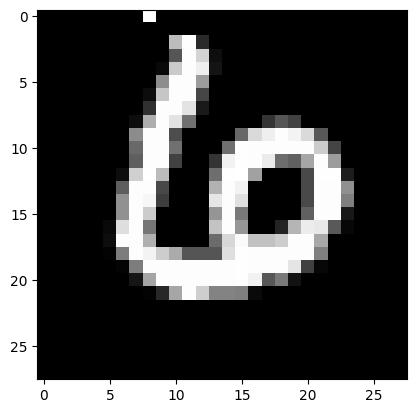

In [52]:
# prediction test & visualization
x,y = next(iter(train_loader))
x,y = x.to(device),y.to(device)
neg_x = model.construct_supervised_example(x,y,False)
print("Prediction: ", model.predict(x,device))
print(" Label: ",y)
plt.imshow(neg_x[0].squeeze().cpu(), cmap='gray')
plt.show()

In [54]:
# plot positive goodness and negative goodness
epoch_axis = torch.arange(0.25,15.25,0.25)
for i in range(len(total_pos_goodnesses)):
    plt.plot(epoch_axis,total_pos_goodnesses[i],label="Positive Goodness Layer {}".format(i))
for i in range(len(total_neg_goodnesses)):
    plt.plot(epoch_axis,total_neg_goodnesses[i],label="Negative Goodness Layer {}".format(i))
plt.x

60

## Previous Model Performance

In [ ]:
model.load_state_dict(torch.load('model_v1.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# adjusted test function (label is messed up when model_v1)
def test_v1():
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for x, label in test_loader:
            test_output = model.predict(x.to(device)) + 1
            if label == 0:
              test_output -= 5
            correct += (test_output == label)
            total += 1
    print()
    print('Test Accuracy of the model on the test set: %.2f' % (correct/total))
test_v1()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f129f0bc310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test Accuracy of the model on the test set: 0.65
